# Perceptron: Linear classification with the Iris data set

**Abstract:** In this tutorial we will:
* Obtain the Iris flower data set
* Load and prepare the respective data set for training
* Implement a Perceptron
* Carry out the training
* Visualize the results

First we import the modules we shall use:
* `Pandas`: for data import
* `Numpy`: for handling operations with arrray
* `Matplotlib`: for plotting the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Next we configure the plotting option:

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

* The magic `%matplot inline` tells IPython to show the plots within the notebook;
* Default figure sizes can be set by `plt.rcParams["figure.figsize"]`;
* The `matplotlib.rc` function changes the resolution of the plots.

We will be using pseudo random numbers, and therefore, need to initialize a seed for the generator. Let us first use a fixed seed to get reproducable results:

In [5]:
np.random.seed(13)

Fix the random seed by, e.g., `np.random.seed(0)` if you need reproducable results.

## Load and prepare the Iris flower data set for our linear classification trials

The first functions we implement fetches the iris data from an internet archive using a call to the Pandas module and saves it in the current directory under the name `iris.csv`. This function needs to called only once, of course.

In [6]:
# module for file access
import os.path

# global file name of our data source
file_name = 'iris.csv'

def fetch_iris_data():
    '''
    Fetch data from an internet archive and save as file `iris.csv`.
    '''

    df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                     header=None)
    df.to_csv(file_name, header=None, index=False)

    return

# fetch data from internet source only if the file is not available locally
if not os.path.exists(file_name):
    fetch_iris_data()

The next cell loads the Iris data from the file `iris.csv` from the current directory into a `Pandas` dataframe.

In [7]:
df = pd.read_csv(file_name, header=None)

The Iris flower data set features three different species: [see here](https://en.wikipedia.org/wiki/Iris_flower_data_set). Let us take a quick look at the data. Here are the first 10 entries:

In [8]:
df[:5]

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


and the entries from 50 to 55:

In [9]:
df[50:55]

,0,1,2,3,4
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor


and finally 5 entries starting from entry 100:

In [10]:
df[100:105]

,0,1,2,3,4
100,6.3,3.3,6.0,2.5,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica
102,7.1,3.0,5.9,2.1,Iris-virginica
103,6.3,2.9,5.6,1.8,Iris-virginica
104,6.5,3.0,5.8,2.2,Iris-virginica


The next function `prep_iris_data` prepares the data for the perceptron training. It reads out the `Pandas` dataframe and stores the desired entries into two `Numpy` arrays which are returned. The first array contains the selected features and the second the labels. Since, here, we only look at a binary classification, we map the three different flow species according to:

* Iris setosa: Label $y=-1$
* All others: Label $y=+1$

Since the data set is sorted by flower species we randomly permute the data before returning the arrays.

In [11]:
def prep_iris_data(df):
    ''' 
    Fetches 2d data points from the iris data from the pandas dataframe `df` and
    return (X, Y), where X is a list of 2d points and Y a list of labels.
    '''
    
    # as feature we take the first two data entries,
    # which are sepal length and width
    X = df.iloc[:, 0:2].values

    # read class labels and convert them to numers as follow:
    # `iris-setosa` set to value -1, `iris-versicol` as well as `iris-virginica` to value 1
    Y = df.iloc[:, 4].values 
    Y = np.where(Y == 'Iris-setosa', -1, 1)
    
    # to make it more realistic, we randomize the data
    indices = np.random.permutation(len(X))
    X_rand = [X[i] for i in indices]
    Y_rand = [Y[i] for i in indices]

    # return the randomized lists as numpy arrays
    return np.array(X_rand), np.array(Y_rand)

Next we need a function to plot the data.

In [12]:
def plot_data(X, Y):
    '''
    Plot the data X, setosa in red, and others in blue.
    '''

    # divide data depedning on the label: iris-setosa or other
    X_setosa = []
    X_other = []
    for x, y in zip(X, Y):
        if y == -1:
            X_setosa.append(x)
        else:
            X_other.append(x)
   
    # convert to numpy array
    X_setosa = np.array(X_setosa)
    X_other = np.array(X_other)

    # plot the two lists with different styles
    plt.scatter(X_setosa[:, 0], X_setosa[:, 1], color='red', marker='o', label='setosa')
    plt.scatter(X_other[:, 0], X_other[:, 1], color='blue', marker='o', label='other')

    # decorate plot
    plt.xlabel('sepal length')
    plt.ylabel('sepal width')
    plt.legend(loc='upper right')

    return

For the plotting the data set is split into the groups 'Iris-setosa' and 'other' according to the preparation of the data in the previous function. Afterwards we plot these two groups in a different style.

Let us load all data from the Iris data set and call the plotting function to take a look at the data:

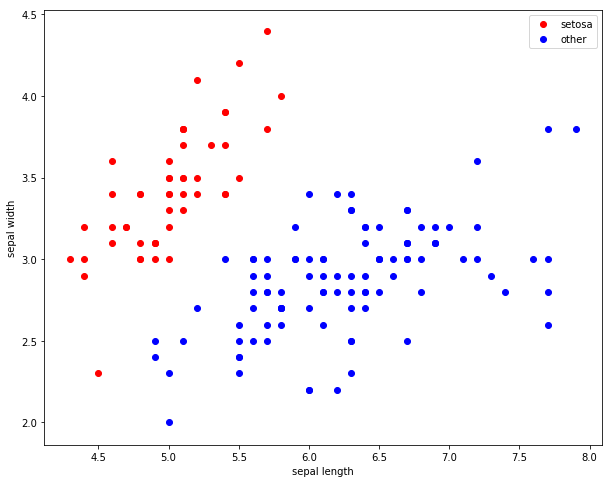

In [13]:
# if you do not have the csv data file call fetch_iris_data() by removing the comment in the line below
# fetch_iris_data()

X_all, Y_all = prep_iris_data(df)

plot_data(X_all, Y_all)

To a good approximation linearly separable. Therefore, without further preparation of the data we can proceed with implementing the perceptron.

## The Perceptron code

We will implement the perceptron as a Python class.

In [14]:
class Perceptron:

    def __init__(self, num):
        '''
        initialize class for `num` input signals
        '''

        # weights of the perceptron, initialized to zero
        # note the '1 + ' as the first weight entry is the threshold
        self.w_ = np.zeros(1 + num)

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return np.where(self.activation_input(X) >= 0.0, 1, -1)

    def learn(self, X_train, Y_train, eta=0.01, epochs=10):
        '''
        fit training features X_train with labels Y_train according to learning rate
        `eta` and total number of epochs `epochs` and log the misclassifications in errors_
        '''

        # reset internal list of misclassifications for the logging
        self.train_errors_ = []

        # repeat `epochs` many times
        for _ in range(epochs):
            err = 0
            # for each pair of features and corresponding label
            for x, y in zip(X_train, Y_train):
                # compute the update for the weight coefficients
                update = eta * ( y - self.classify(x) )
                # update the weights
                self.w_[1:] += update * x
                # update the threshold
                self.w_[0] += update
                # increment the number of misclassifications if update is not zero
                err += int(update != 0.0)
            # append the number of misclassifications to the internal list
            self.train_errors_.append(err)
    
        return

    def plot_decision_regions(self, X, Y, X_train, Y_train, resolution):

        # set up a 2d mesh of data points with resolution `resolution`
        x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
        x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # start new plot
        fig = plt.figure()
        axs = plt.gca()

        # make fictitious feature data out of the above 2d mesh
        x_mesh = np.array( [xx1.ravel(), xx2.ravel()] ).T
        # let the perceptron classify these features
        Z = self.classify(x_mesh)
        Z = Z.reshape(xx1.shape)

        # plot the mesh as contour plot
        axs.contourf(xx1, xx2, Z, alpha=0.4, cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
        axs.set_xlim(xx1.min(), xx1.max())
        axs.set_ylim(xx2.min(), xx2.max())
        
        # sort the input data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X, Y):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)

        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='.', label='Setosa')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='.', label='Other')
        
        # sort the training data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X_train, Y_train):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)
        
        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='x', label='S. training')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='x', label='O. training')

        # add some additional annotations of the plot
        axs.set_xlabel('sepal length')
        axs.set_ylabel('sepal width')
        axs.legend(loc='upper right')
        axs.set_title('Perceptron')

        return

    def plot_train_errors(self):
        '''
        plot the number of misclassifications per epoch
        '''

        # create two list, one with epoch numbers, and one with the errors per epoch
        epochs, num_errs = np.arange(len(self.train_errors_)), np.array(self.train_errors_)

        # plot the above data
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('errors')
        axs.set_title('Errors during training')
        plt.plot(epochs, num_errs)

        return

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

##  Carrying out the training

The data is split into two parts:

* One data set of samples for training 
* and the other one for testing the classification efficiency of the perceptron.

In [16]:
train_samples = int( len(X_all) / 3 )

# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]

# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

Next, we initialize the perceptron:

In [17]:
ppn = Perceptron(X.shape[1])

start the trainning and plot the number of misclassification per epoch:

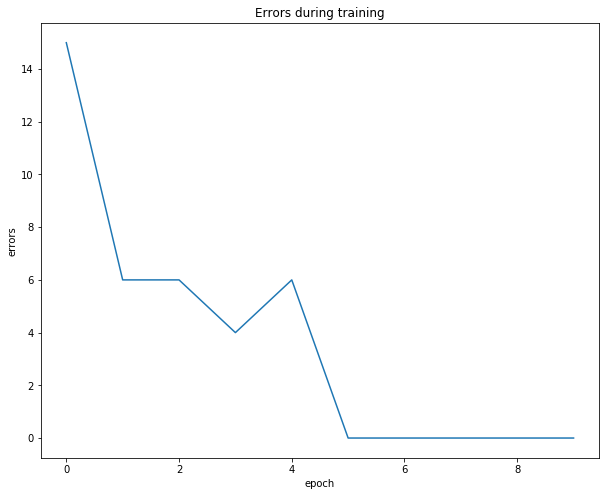

In [18]:
ppn.learn(X_train, Y_train, eta=0.1, epochs=10)
ppn.plot_train_errors()

Next, let us plot the decission regions of the perceptron:

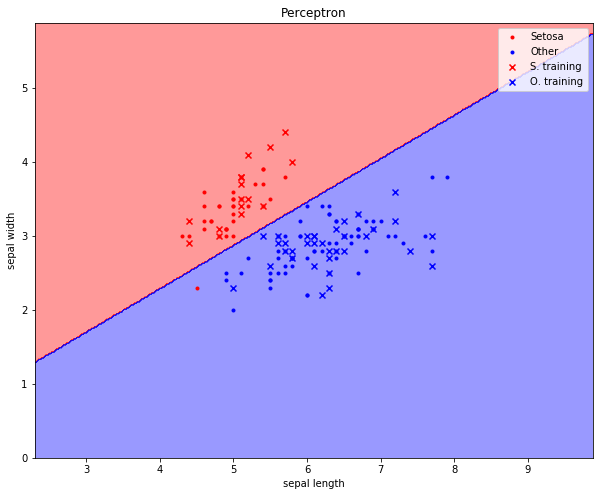

In [16]:
ppn.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

And finally, we compute the overall efficiency:

In [17]:
eff_train = ppn.efficiency(X_train, Y_train)
eff_test = ppn.efficiency(X, Y)
eff_all = ppn.efficiency(X_all, Y_all)

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

Efficiency (train) = 1.0
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9933333333333333


**HOMEWORK:** The decision regions plot obviously shows a misclassification. This is reflected in the computed efficiency but not in 'Error during training' plot. Why?